[![View on GitHub](https://img.shields.io/badge/GitHub-View_on_GitHub-blue?logo=GitHub)](https://github.com/khuyentran1401/Data-science/blob/master/data_science_tools/shapey_values/shapey_values.ipynb)

[<img src="https://deepnote.com/buttons/launch-in-deepnote.svg">](https://deepnote.com/project/Data-science-hxlyJpi-QrKFJziQgoMSmQ/%2FData-science%2Fdata_science_tools%2Fshapey_values%2Fshapey_values.ipynb)

 [![View Article](https://img.shields.io/badge/View%20Article-View%20Full%20Article-red)](https://towardsdatascience.com/shap-explain-any-machine-learning-model-in-python-24207127cad7)

In [ ]:
!pip install shap==0.39.0 patsy==0.5.2 yellowbrick==1.2.1 xgboost==1.4.2 numpy==1.20

In [ ]:
%load_ext watermark
%watermark --iversions

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
xgboost : 1.4.2
psycopg2: 2.9.1 (dt dec pq3 ext lo64)
pandas  : 1.2.5
shap    : 0.39.0



# Intuition

In [ ]:
revenues = {
    "no_ad": 150,
    "social_media": 300,
    "google_advertising": 200,
    "email_marketing": 350,
    "social_media + google_advertising": 320,
    "social_media + email_marketing": 400,
    "google_advertising + email_marketing": 350,
    "social_media + google_advertising + email_marketing": 450,
}

In [ ]:
weights = [1 / 3, 1 / 6, 1 / 6, 1 / 3]

## Google Advertising Marginal Contribution

$MC_1$ = revenue(Google advertisement) - revenue(no ad)
= 200 - 150 = 50


$MC_2$ = revenue(Google advertisement + social media) - revenue(social media)

= 320 - 300 = 20


$MC_3$ = revenue(Google advertisement + email marketing) - revenue(email marketing)
= 350 - 350 = 0


$MC_4$ = revenue(Google advertisement + email marketing + social media) - 

revenue(email marketing + social media) 

= 450 - 400 = 50


$$w_1 \times MC_1 + w_2 \times MC_2 + w_3 \times MC_2 + w_4 \times MC_4$$

where
- $MC_i$ is the marginal contribution of Google advertisement to group $i$ for $i=1, 2, 3, 4$
- $w_i$ denotes the weight of the marginal contribution $MC_i$ for  $i=1, 2, 3, 4$.

\begin{align*}
&w_1 \times MC_1 + w_2 \times MC_2 + w_3 \times MC_2 + w_4 \times MC_4\\
&=\frac{1}{3}\times 50 + \frac{1}{6}\times 20 + \frac{1}{6}\times 0 + \frac{1}{3}\times50\\
&=36.67
\end{align*}

In [ ]:
google_advertising_contribution = [
    revenues["google_advertising"] - revenues["no_ad"],
    revenues["social_media + google_advertising"] - revenues["social_media"],
    revenues["google_advertising + email_marketing"] - revenues["email_marketing"],
    revenues["social_media + google_advertising + email_marketing"]
    - revenues["social_media + email_marketing"],
]
google_advertising_contribution

[50, 20, 0, 50]

In [ ]:
google_advertising_total_contribution = sum(
    [
        weight * contribution
        for weight, contribution in zip(weights, google_advertising_contribution)
    ]
)
google_advertising_total_contribution

36.66666666666666

## Social Media Marginal Contribution

In [ ]:
social_media_contribution = [
    revenues["social_media"] - revenues["no_ad"],
    revenues["social_media + google_advertising"] - revenues["google_advertising"],
    revenues["social_media + email_marketing"] - revenues["email_marketing"],
    revenues["social_media + google_advertising + email_marketing"]
    - revenues["google_advertising + email_marketing"],
]
social_media_contribution

[150, 120, 50, 100]

In [ ]:
social_media_total_contribution = sum(
    [
        weight * contribution
        for weight, contribution in zip(weights, social_media_contribution)
    ]
)
social_media_total_contribution

111.66666666666666

## Email Marketing Marginal Contribution

In [ ]:
email_marketing_contribution = [
    revenues["email_marketing"] - revenues["no_ad"],
    revenues["google_advertising + email_marketing"] - revenues["google_advertising"],
    revenues["social_media + email_marketing"] - revenues["social_media"],
    revenues["social_media + google_advertising + email_marketing"]
    - revenues["social_media + google_advertising"],
]
email_marketing_contribution

[200, 150, 100, 130]

In [ ]:
email_marketing_contribution = sum(
    [
        weight * contribution
        for weight, contribution in zip(weights, email_marketing_contribution)
    ]
)
email_marketing_contribution

151.66666666666663

## Total Contribution

In [ ]:
(
    google_advertising_total_contribution
    + social_media_total_contribution
    + email_marketing_contribution
)

299.99999999999994

# Machine Learning Interpretability With Shap

## Train Model

In [ ]:
import pandas as pd

data = pd.read_csv("/datasets/advertising/advertising.csv")
data.columns = data.columns.map(lambda row: "_".join(row.lower().split(" ")))
data.head(10)

,daily_time_spent_on_site,age,area_income,daily_internet_usage,ad_topic_line,city,male,country,timestamp,clicked_on_ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0
5,59.99,23,59761.56,226.74,Sharable client-driven software,Jamieberg,1,Norway,2016-05-19 14:30:17,0
6,88.91,33,53852.85,208.36,Enhanced dedicated support,Brandonstad,0,Myanmar,2016-01-28 20:59:32,0
7,66.00,48,24593.33,131.76,Reactive local challenge,Port Jefferybury,1,Australia,2016-03-07 01:40:15,1
8,74.53,30,68862.00,221.51,Configurable coherent function,West Colin,1,Grenada,2016-04-18 09:33:42,0
9,69.88,20,55642.32,183.82,Mandatory homogeneous architecture,Ramirezton,1,Ghana,2016-07-11 01:42:51,0


In [ ]:
from patsy import dmatrices

y, X = dmatrices(
    "clicked_on_ad ~ daily_time_spent_on_site + age + area_income + daily_internet_usage  + male -1",
    data=data,
)

In [ ]:
X_frame = pd.DataFrame(data=X, columns=X.design_info.column_names)
X_frame

,daily_time_spent_on_site,age,area_income,daily_internet_usage,male
0,68.95,35.0,61833.90,256.09,0.0
1,80.23,31.0,68441.85,193.77,1.0
2,69.47,26.0,59785.94,236.50,0.0
3,74.15,29.0,54806.18,245.89,1.0
4,68.37,35.0,73889.99,225.58,0.0
...,...,...,...,...,...
995,72.97,30.0,71384.57,208.58,1.0
996,51.30,45.0,67782.17,134.42,1.0
997,51.63,51.0,42415.72,120.37,1.0
998,55.55,19.0,41920.79,187.95,0.0


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)

In [ ]:
import xgboost
import shap
from sklearn.metrics import f1_score

model = xgboost.XGBClassifier().fit(X_train, y_train)

prediction = model.predict(X_test)
f1 = f1_score(y_test, prediction)
f1

2021-10-12 11:44:27.756124: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-10-12 11:44:27.756182: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
[11:44:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error

0.9619047619047619

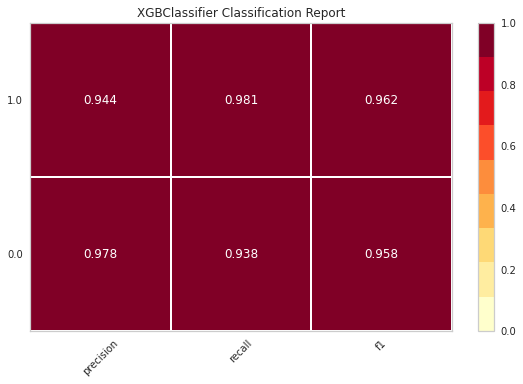

<AxesSubplot:title={'center':'XGBClassifier Classification Report'}>

In [ ]:
from yellowbrick.classifier import ClassificationReport

visualizer = ClassificationReport(model)
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

## SHAP Summary Plot

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(X_frame)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


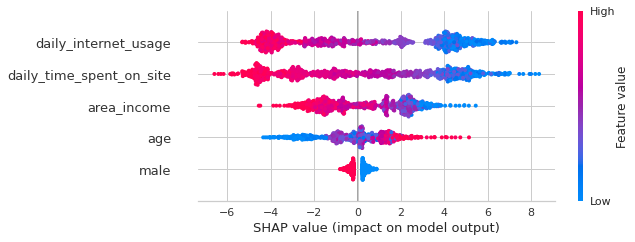

In [ ]:
shap.summary_plot(shap_values, X)

## SHAP Waterfall Plot

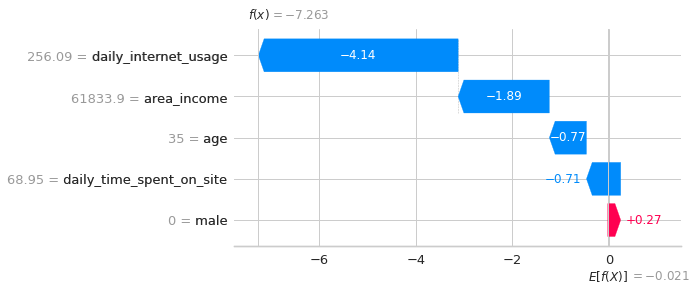

In [ ]:
shap.plots.waterfall(shap_values[0])

$f(x)$ is the prediction after considering all features

$E[f(x)]$ is the mean prediction

$$f(x) - E[f(x)] = -7.263 - (-0.021) = -7.24$$
$$\text{total contribution} = -4.14 - 1.89 - 0.77 - 0.71 + 0.27=-7.24$$

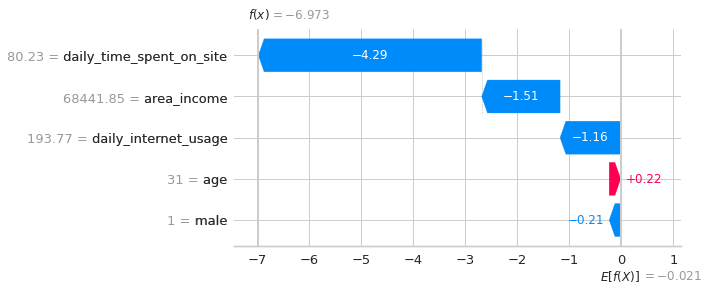

In [ ]:
shap.plots.waterfall(shap_values[1])

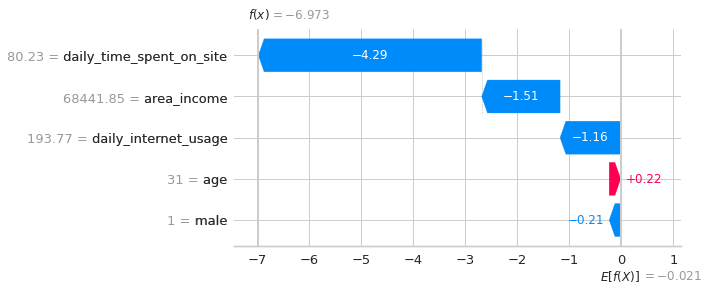

In [ ]:
shap.plots.waterfall(shap_values[1])

### SHAP Scatter Plot

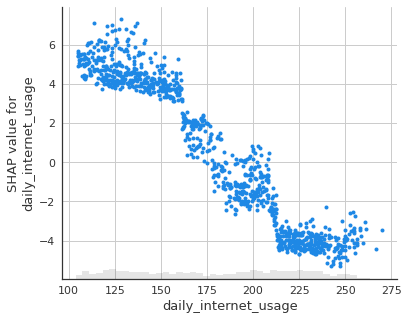

In [ ]:
shap.plots.scatter(shap_values[:, "daily_internet_usage"])

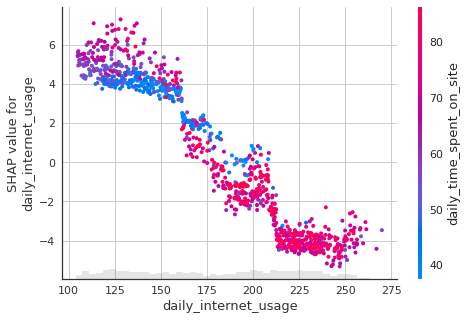

In [ ]:
shap.plots.scatter(shap_values[:, "daily_internet_usage"], color=shap_values)

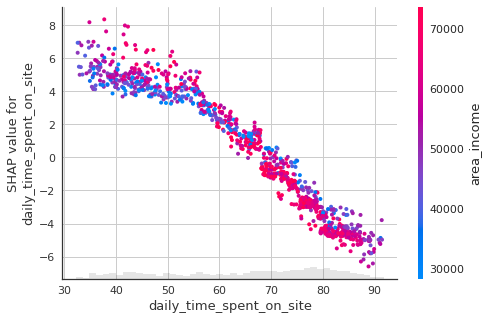

In [ ]:
shap.plots.scatter(shap_values[:, "daily_time_spent_on_site"], color=shap_values)

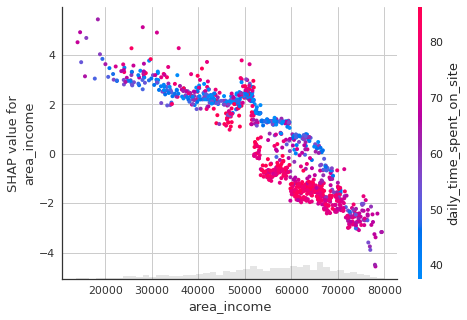

In [ ]:
shap.plots.scatter(shap_values[:, "area_income"], color=shap_values)

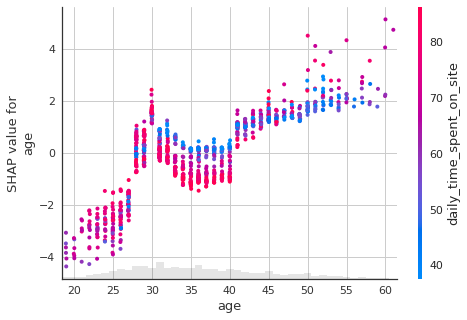

In [ ]:
shap.plots.scatter(shap_values[:, "age"], color=shap_values)

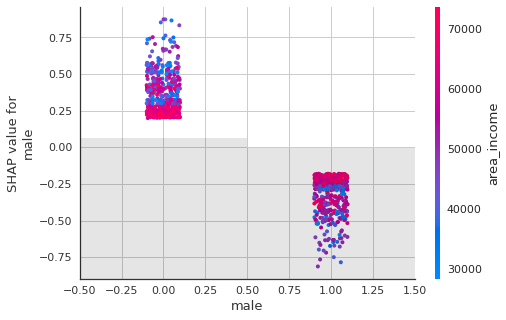

In [ ]:
shap.plots.scatter(shap_values[:, "male"], color=shap_values)

## SHAP Bar Plot

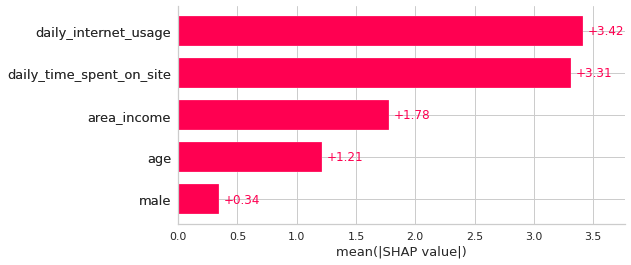

In [ ]:
shap.plots.bar(shap_values)

## SHAP Interaction Value Summary Plot

In [ ]:
shap_interaction_values = explainer.shap_interaction_values(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


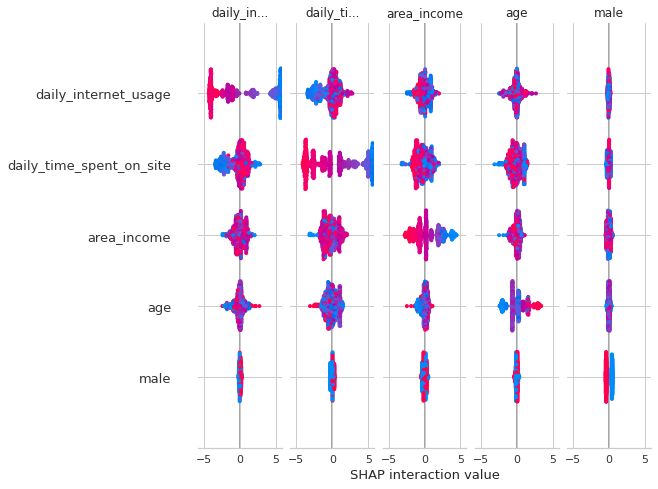

In [ ]:
shap.summary_plot(shap_interaction_values, X_frame)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=87197226-98be-42b2-8527-389082831299' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>